In [4]:
import pandas as pd 
import numpy as np 
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from nltk.tokenize import TweetTokenizer
from collections import defaultdict

In [6]:
# read data
dataset_path = 'data/sentiment_analysis.csv' 
df = pd.read_csv(
        dataset_path ,
        index_col='id' )

In [7]:
def text_normalize(text):
    # Retweet old acronym "RT" removal 
    text = re.sub(r"^RT[\s]+", "", text)
    # Hyperlinks removal
    text = re.sub(r"https?:\/\/.*[\r\n]*", "", text) # Hashtags removal
    text = re.sub(r"#", "", text) # Punctuation removal
    text = re.sub(r"[^\w\s]", "", text)
    # Tokenization
    tokenizer = TweetTokenizer( preserve_case=False, strip_handles=True, reduce_len=True
    )
    text_tokens = tokenizer.tokenize(text)
    return text_tokens

In [12]:
# get freqs of token corresponding to each class
def get_freqs(df):
    freqs = defaultdict(lambda:0)
    for idx,row in df.iterrows():
        tweet = row['tweet']
        label = row['label']
        tokens = text_normalize(tweet)
        for token in tokens:
            pair = (token,label)
            freqs[pair] +=1
    return freqs

In [13]:
# get feature 
def get_feature(text,freqs):
    tokens = text_normalize(text)
    X = np.zeros(3)
    X[0] = 1
    for token in tokens:
        X[1] += freqs[(token,0)]
        X[2] += freqs[(token,1)]
    return X

In [14]:
X = [] 
y = []
freqs = get_freqs(df)
for idx, row in df.iterrows():
    tweet = row["tweet"] 
    label = row["label"]
    X_i = get_feature(tweet, freqs)
    X.append(X_i)
    y.append(label)
X = np.array(X)
y = np.array(y)

    

In [16]:
# split data
val_size = 0.3
test_size = 0.1
random_state = 2
shuffle = True
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=val_size,shuffle=shuffle,random_state=random_state)
X_val,X_test,y_val,y_test = train_test_split(X_val,y_val,test_size=test_size,shuffle=shuffle,random_state=random_state)

In [17]:
# normalize data
# nomalize data
nomalizer = StandardScaler()
X_train[:,1:] = nomalizer.fit_transform(X_train[:,1:])
X_val[:,1:] = nomalizer.transform(X_val[:,1:])
X_test[:,1:] = nomalizer.transform(X_test[:,1:])

In [18]:
class LogisticRegression():
    def __init__(self,lr= 0.01,epochs = 100,batch_size = 128,threshold = 0.5):
        self.W = None
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.threshold = threshold
        pass
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    def predict(self,X):
        y_hat = self.sigmoid(X.dot(self.W))
        return y_hat
    def gradient(self,x,y_hat,y):
        return (x.T.dot(y_hat - y))/y_hat.shape[0]
        
    def update_weight(self,x,y_hat,y):
        self.W = self.W - self.gradient(x,y_hat,y)*self.lr
    def compute_loss(self,y_hat,y):
       
        y_hat = np.clip(y_hat, 1e-7, 1 - 1e-7 )
        
        loss = -y*np.log(y_hat) - (1-y)*np.log(1-y_hat)
        return np.mean(loss)
    def compute_accracy(self,y_hat,y):
        
        predicted_label = (y_hat > self.threshold).astype(int)
        return (predicted_label == y).sum()/y.shape[0]
    
    def train(self,X_train,Y_train,X_val,Y_val):
        np.random.seed(random_state) 
        self.W = np.random.uniform(
                        size=X_train.shape[1] )
        train_accs = [] 
        train_losses = []
        val_accs = [] 
        val_losses = []
        for epoch in range(self.epochs):
            train_batch_losses = [] 
            train_batch_accs = [] 
            val_batch_losses = [] 
            val_batch_accs = []
            for batch in range(0,X_train.shape[0] - self.batch_size +1,self.batch_size):
                x_train = X_train[self.batch_size:self.batch_size+self.batch_size]
                y_train = Y_train[self.batch_size:self.batch_size+self.batch_size]
                
                y_hat_train = self.predict(x_train)
                
                self.update_weight(x_train,y_hat_train,y_train)
               
                train_batch_losses.append(self.compute_loss(y_hat_train,y_train))
                
              
            for batch in range(0,X_val.shape[0] - self.batch_size +1,self.batch_size):
               
                x_val = X_val[self.batch_size:self.batch_size+self.batch_size]
                y_val = Y_val[self.batch_size:self.batch_size+self.batch_size]
                
               
                y_hat_val = self.predict(x_val)
              
                val_batch_losses.append(self.compute_loss(y_hat_val,y_val))
            
        
            
            train_batch_loss = sum(train_batch_losses) / len(train_batch_losses) 
            val_batch_loss = sum(val_batch_losses) / len(val_batch_losses) 
            train_losses.append(train_batch_loss) 
            val_losses.append(val_batch_loss) 
            train_accs.append(self.compute_accracy(self.predict(X_train),Y_train)) 
            val_accs.append(self.compute_accracy(self.predict(X_val),Y_val))
            print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_batch_loss:.3f}\tValidation loss: {val_batch_loss:.3f}')
    
        
        
        fig, ax = plt.subplots(2, 2, figsize=(12, 10)) 
        ax[0, 0].plot(train_losses)
        ax[0, 0].set(xlabel='Epoch', ylabel='Loss') 
        ax[0, 0].set_title('Training Loss')
        ax[0, 1].plot(val_losses , 'orange')
        ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
        ax[0, 1].set_title('Validation Loss')
        ax[1, 0].plot(train_accs)
        ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy') 
        ax[1, 0].set_title('Training Accuracy')
        ax[1, 1].plot(val_accs , 'orange')
        ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy') 
        ax[1, 1].set_title('Validation Accuracy')
        plt.show()
                
        
        



EPOCH 1:	Training loss: 0.714	Validation loss: 0.703

EPOCH 2:	Training loss: 0.672	Validation loss: 0.660

EPOCH 3:	Training loss: 0.637	Validation loss: 0.623

EPOCH 4:	Training loss: 0.608	Validation loss: 0.593

EPOCH 5:	Training loss: 0.584	Validation loss: 0.568

EPOCH 6:	Training loss: 0.564	Validation loss: 0.546

EPOCH 7:	Training loss: 0.547	Validation loss: 0.528

EPOCH 8:	Training loss: 0.533	Validation loss: 0.512

EPOCH 9:	Training loss: 0.520	Validation loss: 0.499

EPOCH 10:	Training loss: 0.510	Validation loss: 0.487

EPOCH 11:	Training loss: 0.501	Validation loss: 0.477

EPOCH 12:	Training loss: 0.493	Validation loss: 0.468

EPOCH 13:	Training loss: 0.487	Validation loss: 0.460

EPOCH 14:	Training loss: 0.481	Validation loss: 0.453

EPOCH 15:	Training loss: 0.475	Validation loss: 0.447

EPOCH 16:	Training loss: 0.471	Validation loss: 0.442

EPOCH 17:	Training loss: 0.466	Validation loss: 0.437

EPOCH 18:	Training loss: 0.463	Validation loss: 0.432

EPOCH 19:	Training

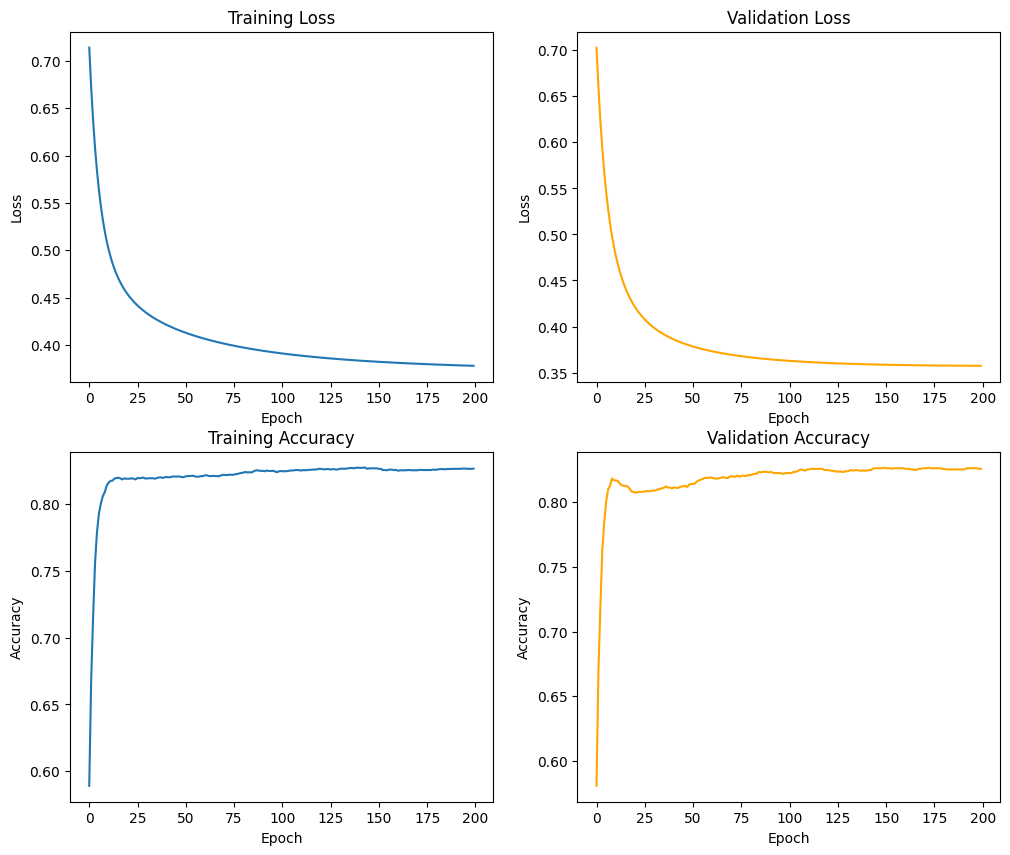

In [20]:
model = LogisticRegression(epochs=200)
model.train(X_train,y_train,X_val,y_val)

In [21]:
val_set_acc = model.compute_accracy(model.predict(X_val), y_val) 
test_set_acc = model.compute_accracy(model.predict(X_test) , y_test) 
print('Evaluation on validation and test set:') 
print(f'Accuracy: {val_set_acc}')
print(f'Accuracy: {test_set_acc}')

Evaluation on validation and test set:
Accuracy: 0.8255378858746492
Accuracy: 0.8613445378151261
